In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing

In [ ]:
df = pd.read_csv('../../Data/CSV-files/dataset-of-00sv2.csv')
#df = pd.read_csv('../../Data/CSV-files/dataset-of-90sv2.csv')
#df = pd.read_csv('../../Data/CSV-files/dataset-of-60sv2.csv')
df.head(1)

In [ ]:
def process_data(dataframe):
    data = dataframe.sample(frac=1)
    data.drop(["track","artist","uri"],axis=1,inplace=True)
    
    target = data.iloc[:,[15]]
    
    #Fjerner kolonnen target
    unscaled_inputs = data.loc[:,data.columns != 'target']
    
    #Skaler dataen, samler verdier rundt 0
    scaled_inputs = preprocessing.scale(unscaled_inputs)
    #scaled_inputs er typen array 
    
    samples_count = scaled_inputs.shape[0]
    train_samples_count = int(0.8*samples_count)
    validation_samples_count = int(0.1*samples_count)
    test_samples_count = samples_count - train_samples_count - validation_samples_count
    
    train_inputs = scaled_inputs[:train_samples_count]
    train_targets = target[:train_samples_count]

    validation_inputs = scaled_inputs[train_samples_count:train_samples_count+validation_samples_count]
    validation_targets = target[train_samples_count:train_samples_count+validation_samples_count]

    test_inputs = scaled_inputs[train_samples_count+validation_samples_count:]
    test_targets = target[train_samples_count+validation_samples_count:]
    
    np.savez('Spotify_data_train', inputs=train_inputs, targets=train_targets)
    np.savez('Spotify_data_validation', inputs=validation_inputs, targets=validation_targets)
    np.savez('Spotify_data_test', inputs=test_inputs, targets=test_targets)
    
    npz = np.load('Spotify_data_train.npz')
    train_inputs,train_targets = npz['inputs'].astype(np.float),npz['targets'].astype(np.int)

    npz = np.load('Spotify_data_validation.npz')
    validation_inputs, validation_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

    npz = np.load('Spotify_data_test.npz')
    test_inputs, test_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)
    
    return [train_inputs,train_targets,validation_inputs, validation_targets, test_inputs, test_targets ]

In [ ]:
#Definerer variabler som brukes senere:
data = process_data(df)
train_inputs = data[0]
train_targets = data[1]
validation_inputs = data[2] 
validation_targets = data[3]
test_inputs = data[4]
test_targets = data[5]

In [ ]:
def build_model():
    # Set the input and output sizes
    input_size = 17 # count of features
    output_size = 2 # count of targets
    # Use same hidden layer size for both hidden layers. Not a necessity.
    hidden_layer_size = 50 # counts of neurons

    # define how the model will look like
    #Stacker ulike lak med hidden layer "oppå" hverandre i modellen 
    model = tf.keras.Sequential([
        # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
        # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3nd hidden layer
        # the final layer is no different, we just make sure to activate it with softmax
        tf.keras.layers.Dense(output_size, activation='softmax') # output layer
    ])
    return model

In [ ]:
def compile_model(model):
    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def fit_model(model):
    # That's where we train the model we have built.
    # set the batch size
    batch_size = 300
    # set a maximum number of training epochs
    max_epochs = 10

    # fit the model
    # note that this time the train, validation and test data are not iterable
    history = model.fit(  train_inputs, # train inputs
                          train_targets, # train targets
                          batch_size=batch_size, # batch size
                          epochs=max_epochs, # epochs that we will train for (assuming early stopping doesn't kick in)
                          # callbacks are functions called by a task when a task is completed
                          # task here is to check if val_loss is increasing
                          #callbacks=[early_stopping], # early stopping
                          validation_data=(validation_inputs, validation_targets), # validation data
                          verbose = 2 # making sure we get enough information about the training process
              ) 
    return history

In [ ]:
def plot_history(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    accuracy = history.history['accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, validation_loss, 'b-')
    plt.plot(epoch_count,accuracy)
    plt.legend(['Training Loss', 'Validation Loss','Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

In [ ]:
def evaluate_model():
    test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)
    print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

In [ ]:
model = build_model()
compile_model(model)
history = fit_model(model)
plot_history(history)
evaluate_model()

In [ ]:
def plot_value_array(i, predictions_array, true_label):
    true_label = test_targets[i]
    plt.grid(False)

    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.ylabel("{:2.0f}%".format(100*np.max(predictions_array),color=color))

    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')


In [ ]:
def plot_result(rows,cols):
    plt.figure(figsize=(2*2*cols, 2*rows))
    for i in range(rows*cols):
        plt.subplot(rows, 2*cols, 2*i+2)
        plot_value_array(i, predictions[i], test_targets)
    plt.tight_layout()
    plt.show()

In [ ]:
probability_model = tf.keras.Sequential([model,                                          tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_inputs)

In [ ]:
plot_result(5,5)

In [ ]:
def get_wrong_guess_data():
    wrong_guess = []
    for i in range(100):
        index = np.argmax(predictions[i])
        if(index!=test_targets[i]):
            arr = np.concatenate((test_inputs[i],test_targets[i])) 
            wrong_guess.append(arr)
            #wrong_guess.append(test_targets[i])
    return wrong_guess

In [151]:
def run_network(path):
    df = pd.read_csv(path)
    data = process_data(df)
    train_inputs = data[0]
    train_targets = data[1]
    validation_inputs = data[2] 
    validation_targets = data[3]
    test_inputs = data[4]
    test_targets = data[5]
    model = build_model()
    compile_model(model)
    history = fit_model(model)
    plot_history(history)
    evaluate_model()

Epoch 1/10
24/24 - 0s - loss: 0.6153 - accuracy: 0.6598 - val_loss: 0.5510 - val_accuracy: 0.7014
Epoch 2/10
24/24 - 0s - loss: 0.5482 - accuracy: 0.7118 - val_loss: 0.5342 - val_accuracy: 0.7269
Epoch 3/10
24/24 - 0s - loss: 0.5267 - accuracy: 0.7328 - val_loss: 0.5258 - val_accuracy: 0.7407
Epoch 4/10
24/24 - 0s - loss: 0.5160 - accuracy: 0.7370 - val_loss: 0.5217 - val_accuracy: 0.7477
Epoch 5/10
24/24 - 0s - loss: 0.5068 - accuracy: 0.7444 - val_loss: 0.5134 - val_accuracy: 0.7535
Epoch 6/10
24/24 - 0s - loss: 0.4985 - accuracy: 0.7495 - val_loss: 0.5079 - val_accuracy: 0.7593
Epoch 7/10
24/24 - 0s - loss: 0.4919 - accuracy: 0.7542 - val_loss: 0.5087 - val_accuracy: 0.7546
Epoch 8/10
24/24 - 0s - loss: 0.4859 - accuracy: 0.7596 - val_loss: 0.5002 - val_accuracy: 0.7627
Epoch 9/10
24/24 - 0s - loss: 0.4775 - accuracy: 0.7665 - val_loss: 0.4977 - val_accuracy: 0.7650
Epoch 10/10
24/24 - 0s - loss: 0.4861 - accuracy: 0.7626 - val_loss: 0.4955 - val_accuracy: 0.7627


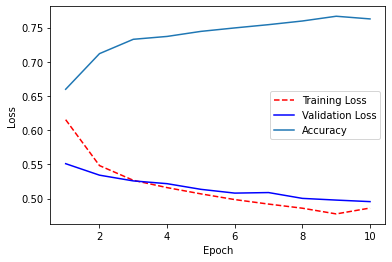

28/28 [==============================] - 0s 2ms/step - loss: 0.5003 - accuracy: 0.7538


In [152]:
run_network('../../Data/CSV-files/dataset-of-00sv2.csv')